# 导入包

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
import scorecardpy as sc
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x) #数值不显示科学计数法，保留两位小数
np.set_printoptions(suppress=True)

# 读入数据

In [3]:
data=pd.read_csv('./data/3_train.csv')

In [4]:
data.head()

,ID,area,ck,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,...,dep-avg,dep-9201,fed-9201,fed-avg,comp,ck-changame,dep-changame,ck-changtime,dep-changtime,VV
0,3,709,0,?,NaN,?,?,0,NaN,?,...,0,0,NaN,0,0,0,0,0,0,0
1,4,.,NaN,0,0,0,NaN,0,0,?,...,0,?,?,0,0,0,0,0,0,0
2,5,616,?,0,.,0,0,0,NaN,0,...,0,NaN,0,.,0,0,0,0,.,0
3,6,615,0,0,0,?,NaN,?,0,0,...,0,0,0,NaN,0,0,0,0,0,0
4,7,.,0,0,0,NaN,.,?,0,NaN,...,0,0,0,0,?,0,0,?,0,0


# 异常字符处理

In [5]:
#去除所有半角全角符号，只留字母、数字、中文
for col in data.columns:
    data[col].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z0-9\u4e00-\u9fa5]', value=np.nan)

In [6]:
data.head()

,ID,area,ck,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,...,dep-avg,dep-9201,fed-9201,fed-avg,comp,ck-changame,dep-changame,ck-changtime,dep-changtime,VV
0,3,709,0,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0,NaN,0,0,0,0,0,0,0
1,4,NaN,NaN,0,0,0,NaN,0,0,NaN,...,0,NaN,NaN,0,0,0,0,0,0,0
2,5,616,NaN,0,NaN,0,0,0,NaN,0,...,0,NaN,0,NaN,0,0,0,0,NaN,0
3,6,615,0,0,0,NaN,NaN,NaN,0,0,...,0,0,0,NaN,0,0,0,0,0,0
4,7,NaN,0,0,0,NaN,NaN,NaN,0,NaN,...,0,0,0,0,NaN,0,0,NaN,0,0


# 缺失值处理

## 查看缺失的列

In [7]:
#查看缺失值的列
na_cols = data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print('{:*^60}'.format('NA Cols:'))
print(na_cols[na_cols==True])  # 查看具有缺失值的列
print('Total number of NA lines is: {0}'.format(
    data.isnull().any(axis=1).sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
area             True
ck               True
ck-saveall       True
ck-drawall       True
ck-savetime      True
ck-drawtime      True
ck-saveavg       True
ck-drawavg       True
ck-avg           True
dep-saveall      True
dep-drawall      True
dep-savetime     True
dep-drawtime     True
depsaveavg       True
depdrawavg       True
dep-avg          True
dep-9201         True
fed-9201         True
fed-avg          True
comp             True
ck-changame      True
dep-changame     True
ck-changtime     True
dep-changtime    True
dtype: bool
Total number of NA lines is: 26114


## 查看数据类型和分布

In [8]:
# 数据分布查看
print('{:*^60}'.format('Data dtypes:'))
print(pd.DataFrame(data.dtypes).T)  # 打印数据类型分布
print('{:*^60}'.format('Data DESC:'))
print(data.describe().round(2).T)  # 打印原始数据基本描述性信息

************************Data dtypes:************************
      ID    area      ck ck-saveall ck-drawall ck-savetime ck-drawtime  \
0  int64  object  object     object     object      object      object   

  ck-saveavg ck-drawavg  ck-avg  ... dep-avg dep-9201 fed-9201 fed-avg  \
0     object     object  object  ...  object   object   object  object   

     comp ck-changame dep-changame ck-changtime dep-changtime     VV  
0  object      object       object       object        object  int64  

[1 rows x 26 columns]
*************************Data DESC:*************************
      count     mean     std  min     25%      50%      75%      max
ID 26144.00 16333.48 9429.67 3.00 8139.25 16340.50 24498.25 32682.00
VV 26144.00     0.02    0.15 0.00    0.00     0.00     0.00     1.00


In [9]:
data.columns

Index(['ID', 'area', 'ck', 'ck-saveall', 'ck-drawall', 'ck-savetime',
       'ck-drawtime', 'ck-saveavg', 'ck-drawavg', 'ck-avg', 'dep-saveall',
       'dep-drawall', 'dep-savetime', 'dep-drawtime', 'depsaveavg',
       'depdrawavg', 'dep-avg', 'dep-9201', 'fed-9201', 'fed-avg', 'comp',
       'ck-changame', 'dep-changame', 'ck-changtime', 'dep-changtime', 'VV'],
      dtype='object')

## 连续变量均值填补

### 分析缺失原因

In [10]:
# 查看数据发现，不管是否有支存，支存类变量都有缺失，说明数据是随机缺失，采用整体缺失填补
data.loc[data['ck']=='0']

,ID,area,ck,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,...,dep-avg,dep-9201,fed-9201,fed-avg,comp,ck-changame,dep-changame,ck-changtime,dep-changtime,VV
0,3,709,0,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0,NaN,0,0,0,0,0,0,0
3,6,615,0,0,0,NaN,NaN,NaN,0,0,...,0,0,0,NaN,0,0,0,0,0,0
4,7,NaN,0,0,0,NaN,NaN,NaN,0,NaN,...,0,0,0,0,NaN,0,0,NaN,0,0
5,9,608,0,0,0,0,0,NaN,0,0,...,0,0,0,NaN,0,0,NaN,0,NaN,0
9,15,NaN,0,0,NaN,NaN,NaN,0,0,NaN,...,0,NaN,0,0,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26137,32675,320,0,0,NaN,0,NaN,0,0,0,...,29713,31930,0,0,1,0,NaN,0,13,0
26138,32677,40400,0,0,0,NaN,0,0,0,0,...,69953,6000,0,0,0,0,44500,0,6,0
26140,32679,83000,0,NaN,0,0,0,0,NaN,0,...,25566,0,0,NaN,0,0,NaN,0,0,0
26141,32680,10400,0,0,0,0,0,0,0,0,...,2173,0,0,0,0,0,0,0,0,0


### 确认填补方法--均值填补

In [11]:
#由Excel列名和业务知识可知，哪些便利是数值型，哪些变量类别型
# 连续变量由字符型转换为数值型
continuous_columns=['ck-saveall', 'ck-drawall', 'ck-savetime',
       'ck-drawtime', 'ck-saveavg', 'ck-drawavg', 'ck-avg', 'dep-saveall',
       'dep-drawall', 'dep-savetime', 'dep-drawtime', 'depsaveavg',
       'depdrawavg', 'dep-avg', 'dep-9201', 'fed-9201', 'fed-avg', 
       'ck-changame', 'dep-changame', 'ck-changtime', 'dep-changtime']
for col in continuous_columns:
    data[col]=data[col].astype(float)

In [12]:
data.describe()

,ID,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,dep-saveall,dep-drawall,...,depdrawavg,dep-avg,dep-9201,fed-9201,fed-avg,ck-changame,dep-changame,ck-changtime,dep-changtime,VV
count,26144.00,19512.00,19533.00,19673.00,19582.00,19627.00,19658.00,19580.00,19743.00,19669.00,...,19633.00,19633.00,19633.00,19786.00,19518.00,19463.00,19587.00,19482.00,19602.00,26144.00
mean,16333.48,5675021.71,952039.47,3.83,6.78,40285.58,30717.81,2038.22,20272164.74,16514883.80,...,201777.53,26160.50,2865627.05,4215.53,3178.10,4974545.50,704112.43,6.10,10.88,0.02
std,9429.67,598325216.34,14577098.30,19.08,49.65,633309.09,736919.60,29398.59,481005494.84,432821060.02,...,2021412.88,340748.34,203794002.08,234941.62,220335.71,590511606.23,6300196.94,42.28,142.52,0.15
min,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8139.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16340.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,148.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,24498.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,327653.50,510000.00,...,51500.00,2766.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,32682.00,83504965431.00,1065646304.00,997.00,3418.00,50745062.00,53282315.00,2709988.00,27927712876.00,27925927928.00,...,185485594.00,28225613.00,28209421276.00,29707259.00,24994127.00,82346336294.00,442896617.00,2846.00,16860.00,1.00


In [13]:
# 数值变量均值填补
# 连续变量由字符型转换为数值型
continuous_columns=['ck-saveall', 'ck-drawall', 'ck-savetime',
       'ck-drawtime', 'ck-saveavg', 'ck-drawavg', 'ck-avg', 'dep-saveall',
       'dep-drawall', 'dep-savetime', 'dep-drawtime', 'depsaveavg',
       'depdrawavg', 'dep-avg', 'dep-9201', 'fed-9201', 'fed-avg', 
       'ck-changame', 'dep-changame', 'ck-changtime', 'dep-changtime']
for col in continuous_columns:
    data[col].fillna(value=data[col].mean() , inplace=True)

## 类别变量众数填补

In [14]:
# 类别变量众数填补
category_columns=['area','ck','comp']
for col in category_columns:
    col_mode=data.loc[:,col].values.reshape(-1,1)
    imp_mode=SimpleImputer(strategy = "most_frequent")
    data.loc[:,col] = imp_mode.fit_transform(col_mode)

In [15]:
# 类别变量转换为字符型
category_columns=['area','ck','comp']
for col in category_columns:
    data[col]=data[col].astype(str)

In [16]:
data.head()

,ID,area,ck,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,...,dep-avg,dep-9201,fed-9201,fed-avg,comp,ck-changame,dep-changame,ck-changtime,dep-changtime,VV
0,3,709,0,5675021.71,952039.47,3.83,6.78,0.00,30717.81,2038.22,...,0.00,0.00,4215.53,0.00,0,0.00,0.00,0.00,0.00,0
1,4,104,0,0.00,0.00,0.00,6.78,0.00,0.00,2038.22,...,0.00,2865627.05,4215.53,0.00,0,0.00,0.00,0.00,0.00,0
2,5,616,0,0.00,952039.47,0.00,0.00,0.00,30717.81,0.00,...,0.00,2865627.05,0.00,3178.10,0,0.00,0.00,0.00,10.88,0
3,6,615,0,0.00,0.00,3.83,6.78,40285.58,0.00,0.00,...,0.00,0.00,0.00,3178.10,0,0.00,0.00,0.00,0.00,0
4,7,104,0,0.00,0.00,3.83,6.78,40285.58,0.00,2038.22,...,0.00,0.00,0.00,0.00,0,0.00,0.00,6.10,0.00,0


# 变量处理

## area区域变量类别太多，需要处理成大分类

In [17]:
# area处理，转换成大类别
data['area_act']=data['area'].str[0]
data.area_act.value_counts()

1    12907
2     3843
4     2769
8     1936
7     1804
3     1753
9      499
6      390
5      237
0        6
Name: area_act, dtype: int64

## 类别变量one-hot转换

In [18]:
from sklearn.preprocessing import OneHotEncoder
# one-hot转换
X = data[['ck','comp','area_act']] #选取要one-hot的列

enc = OneHotEncoder(categories='auto').fit(X)
result = enc.transform(X).toarray()

print(enc.get_feature_names())#返回每一个经过哑变量后生成稀疏矩阵列的名字

#axis=1,表示跨行进行合并，也就是将两表左右相连，如果是axis=0，就是将量表上下相连
newdata = pd.concat([data,pd.DataFrame(result)],axis=1)
 
newdata.drop(['ID','area','ck','comp','area_act'],axis=1,inplace=True)

print(newdata.columns) #提取列名

#重命名
newdata.columns = [   'ck-saveall',    'ck-drawall',   'ck-savetime',   'ck-drawtime',
          'ck-saveavg',    'ck-drawavg',        'ck-avg',   'dep-saveall',
         'dep-drawall',  'dep-savetime',  'dep-drawtime',    'depsaveavg',
          'depdrawavg',       'dep-avg',      'dep-9201',      'fed-9201',
             'fed-avg',   'ck-changame',  'dep-changame',  'ck-changtime',
       'dep-changtime','VV','ck_0','ck_1','comp_0', 'comp_1','area_0',
                   'area_1','area_2','area_3','area_4','area_5','area_6','area_7','area_8','area_9']


['x0_0' 'x0_1' 'x1_0' 'x1_1' 'x2_0' 'x2_1' 'x2_2' 'x2_3' 'x2_4' 'x2_5'
 'x2_6' 'x2_7' 'x2_8' 'x2_9']
Index([   'ck-saveall',    'ck-drawall',   'ck-savetime',   'ck-drawtime',
          'ck-saveavg',    'ck-drawavg',        'ck-avg',   'dep-saveall',
         'dep-drawall',  'dep-savetime',  'dep-drawtime',    'depsaveavg',
          'depdrawavg',       'dep-avg',      'dep-9201',      'fed-9201',
             'fed-avg',   'ck-changame',  'dep-changame',  'ck-changtime',
       'dep-changtime',            'VV',               0,               1,
                     2,               3,               4,               5,
                     6,               7,               8,               9,
                    10,              11,              12,              13],
      dtype='object')


# 训练模型

## 目标变量，正负比例

In [19]:
newdata.head()

,ck-saveall,ck-drawall,ck-savetime,ck-drawtime,ck-saveavg,ck-drawavg,ck-avg,dep-saveall,dep-drawall,dep-savetime,...,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9
0,5675021.71,952039.47,3.83,6.78,0.00,30717.81,2038.22,0.00,16514883.80,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,0.00,0.00,0.00,6.78,0.00,0.00,2038.22,0.00,0.00,24.32,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,952039.47,0.00,0.00,0.00,30717.81,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,3.83,6.78,40285.58,0.00,0.00,0.00,16514883.80,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,3.83,6.78,40285.58,0.00,2038.22,20272164.74,16514883.80,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
newdata.VV.value_counts() #看正负样本分布 

0    25554
1      590
Name: VV, dtype: int64

In [21]:
#正负样本比例严重不平衡，对正样本过抽样
from imblearn.over_sampling import SMOTE 

## 用xgboost建立模型

In [22]:
#建模
import sklearn
from sklearn.model_selection import train_test_split
#入模变量
X = newdata[[
    'ck-saveall',    'ck-drawall',   'ck-savetime',   'ck-drawtime',
          'ck-saveavg',    'ck-drawavg',        'ck-avg',   'dep-saveall',
         'dep-drawall',  'dep-savetime',  'dep-drawtime',    'depsaveavg',
          'depdrawavg',       'dep-avg',      'dep-9201',      'fed-9201',
             'fed-avg',   'ck-changame',  'dep-changame',  'ck-changtime',
       'dep-changtime','ck_0','ck_1','comp_0', 'comp_1', 'area_0',
                   'area_1','area_2','area_3','area_4','area_5','area_6','area_7','area_8','area_9'
]]
#目标变量
y=newdata[['VV']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=112)
from xgboost import XGBClassifier
from xgboost import plot_importance
model = XGBClassifier( learning_rate =0.1,n_estimators=1000,max_depth=5,
 min_child_weight=20,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.8,
 #objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model.fit(X_train, y_train,eval_metric='auc')
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


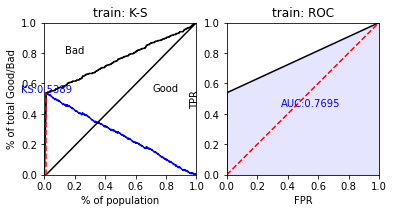

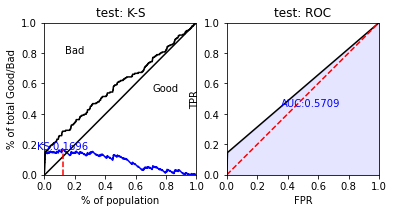

In [23]:
y_train=y_train['VV']
y_test=y_test['VV']
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

## 模型评估

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
print('训练集F1值:%s'%f1_score(train_pred,y_train))
print('验证集F1值:%s'%f1_score(test_pred,y_test))

训练集F1值:0.6921898928024502
验证集F1值:0.21834061135371174


0.9771800101988781
0.14619883040935672
0.6416194707194591


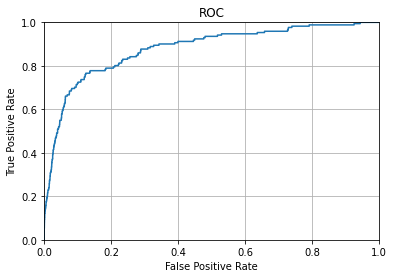

In [25]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, test_pred)
print(accuracy)
recall = metrics.recall_score(y_test, test_pred)
print(recall)
#ROC
y2_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y2_pred_prob)
print(max(tpr-fpr))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# 预测测试集

## 读取数据

In [26]:
test_data=pd.read_csv('Test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Test.csv'

## 测试集数据处理

### 异常字符处理


In [ ]:
#去除所有半角全角符号，只留字母、数字、中文
for col in test_data.columns:
    test_data[col].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z0-9\u4e00-\u9fa5]', value=np.nan)

## 缺失处理

### 连续变量转数值型

In [ ]:
test_data.head()

In [ ]:
# 数值变量均值填补，用训练集数据填补测试集
for col in continuous_columns:
    test_data[col].fillna(value=data[col].mean() , inplace=True)

In [ ]:
# 连续变量由字符型转换为数值型
continuous_columns=['ck-saveall', 'ck-drawall', 'ck-savetime',
       'ck-drawtime', 'ck-saveavg', 'ck-drawavg', 'ck-avg', 'dep-saveall',
       'dep-drawall', 'dep-savetime', 'dep-drawtime', 'depsaveavg',
       'depdrawavg', 'dep-avg', 'dep-9201', 'fed-9201', 'fed-avg', 
       'ck-changame', 'dep-changame', 'ck-changtime', 'dep-changtime']
for col in continuous_columns:
    test_data[col]=test_data[col].astype(float)

### 类别变量处理

In [ ]:
# 类别变量众数填补，用训练集填补测试集
category_columns=['area','ck','comp']
for col in category_columns:
    val = data[col].value_counts().sort_values()
    val = pd.DataFrame(val)
    val['index'] = val.index
    test_data[col].fillna(value = val['index'][-1], inplace=True)

In [ ]:
# 类别变量转换为字符型
category_columns=['area','ck','comp']
for col in category_columns:
    test_data[col]=test_data[col].astype(str)

## 变量处理

### area区域字段处理

In [ ]:
# area处理，转换成大类别
test_data['area_act']=test_data['area'].str[0]

### 类别变量one-hot转换

In [ ]:
# one-hot转换
X = test_data[['ck','comp','area_act']] #选取要one-hot的列

enc = OneHotEncoder(categories='auto').fit(X)
result = enc.transform(X).toarray()

print(enc.get_feature_names())#返回每一个经过哑变量后生成稀疏矩阵列的名字

#axis=1,表示跨行进行合并，也就是将两表左右相连，如果是axis=0，就是将量表上下相连
newdata = pd.concat([test_data,pd.DataFrame(result)],axis=1)
 
newdata.drop(['ID','area','ck','comp','area_act'],axis=1,inplace=True)

print(newdata.columns) #提取列名